In [108]:
!git clone https://github.com/wiguider/Ensemble-Deep-Learning-to-Classify-Scoliosis-and-Healthy-Subjects.git


Cloning into 'Ensemble-Deep-Learning-to-Classify-Scoliosis-and-Healthy-Subjects'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 96 (delta 20), reused 71 (delta 12), pack-reused 0
Receiving objects: 100% (96/96), 1.21 MiB | 9.13 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [112]:
cd /content/Ensemble-Deep-Learning-to-Classify-Scoliosis-and-Healthy-Subjects

/content/Ensemble-Deep-Learning-to-Classify-Scoliosis-and-Healthy-Subjects


In [102]:
import data


In [103]:
import model

In [104]:
import ensemble

In [105]:
import requirements

In [113]:
import train_ensemble

In [114]:
import main

In [88]:
from pandas import read_excel, DataFrame
from sklearn.model_selection import train_test_split
from sklearn import metrics
from ensemble import EnsembleNNClassifier


def load_scoliosis_data():
    dataset = read_excel('data/pone.0261511.s001.xlsx',
                         sheet_name='health-scoliotic patients')
    X = dataset.drop(['Patients','y'], axis=1)
    y = dataset['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=90)
    return X_train, y_train, X_test, y_test

if __name__ == "__main__":
    print('Loading the data')
    X_train, y_train, X_test, y_test = load_scoliosis_data()

    print('Loading the model')
    loaded_clf = EnsembleNNClassifier.load('model')
    status_dict = {1: 'has Scoliosis', 0: 'is Healthy'}

    # feature_names = 'x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25','x26','x27'

    # Making predictions for the first 10 rows in the test set
    ensemble_predictions = [f'Subject {i} ' + status_dict[int(x[0])] for i, x in enumerate(loaded_clf.predict(X_test.iloc[:10]))]
    print()
    print('-------------------------------------------------------------------------' )
    print()
    print('Making predictions for the first 10 rows in the test set' )
    print(ensemble_predictions)
    # Making predictions for two candidate subjects
    candidate_subject = [30.525,-12.75,-3,1.66,12.325,0.395,-0.000718327,-0.3780369,-0.672629766,-0.810873309,-0.909343173,67.085,26.475,41.875,32.18,17.385,3.95,-6.335,0.72,-6.335,7.055,-3.345,2.95,6.23,6.23,-3.33,9.56]
    candidate_subject_1 = [8.37,-12,6,2.12,12.93,3.35,0.007217427,-0.329721479,-0.562601289,-0.787001093,-0.932781819,63.14,37.33,45.21,26.18,10.71,2.17,5.28,5.28,-1.32,6.61,0.91,1.58,-3.13,1.94,-3.13,5.07]
    prediction = loaded_clf.predict([candidate_subject])[0]
    status = status_dict[int(prediction)]
    print(f'The candidate subject {status}')
    prediction = loaded_clf.predict([candidate_subject_1])[0]
    status = status_dict[int(prediction)]
    print(f'The candidate subject {status}')


Loading the data
Loading the model
1/1 [==============================] - 0s 151ms/step

-------------------------------------------------------------------------

Making predictions for the first 10 rows in the test set
['Subject 0 has Scoliosis', 'Subject 1 is Healthy', 'Subject 2 has Scoliosis', 'Subject 3 is Healthy', 'Subject 4 has Scoliosis', 'Subject 5 has Scoliosis', 'Subject 6 has Scoliosis', 'Subject 7 has Scoliosis', 'Subject 8 has Scoliosis', 'Subject 9 is Healthy']
1/1 [==============================] - 0s 103ms/step
The candidate subject has Scoliosis
1/1 [==============================] - 0s 37ms/step
The candidate subject is Healthy


In [38]:
import os
import pickle
import random
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, ReLU, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
from sklearn.metrics import balanced_accuracy_score

# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)
# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value
set_seed(seed_value)


class EnsembleNNClassifier():
    """EnsembleNNClassifier represents an Ensemble Model of Neural Networks
    for binary classification.
    """
    def __init__(self,
                 input_shape,
                 layers_units,
                 n_members=5):
        """EnsembleNNClassifier represents an Ensemble Model of Neural Networks
    for binary classification.

        Args:
            input_shape (Tuple): Shape of the input data. (27,)
            layers_units (Tuple): Tuple representing the number of units in each layer. (64, 64,)
            n_members (int, optional): Number of members in the ensemble model. Defaults to 5.
        """
        self.input_shape = input_shape
        self.layers_units = layers_units
        self.num_hidden_layers = len(layers_units)
        self.n_members = n_members
        self.members = []
        self.score = 0
        self._fitted = False
        if len(self.members)> 0:
            self._fitted = True
        self._build_ensemble()


    def _build_ensemble(self):
        """Builds the ensemble model.
        """
        for model_index in range(self.n_members):
            model_number = model_index + 1
            self._build_model(model_number)

    def compile_ensemble(self):
        """Compiles all models in the ensemble.
        """
        for member in self.members:
            self._compile_model(member)

    def fit_evaluate(self,x_train,y_train, x_test, y_test, epochs=100, batch_size=10, verbose=0):
        """Trains all the models in the ensemble for a fixed number of epochs on the training data,
        and evaluates its performance on the test data

        Args:
            x_train: Input data for training.
            y_train: Target data for training.
            x_test: Input data for testing.
            y_test: Target data for testing.
            epochs (int, optional): number of training epochs. Defaults to 100.
            batch_size (int, optional): batch size. Defaults to 8.
            verbose (int, optional): Verbosity mode. Defaults to 0.
        """
        if self._fitted:
            raise Exception('The model is already fitted')
        #fit all models
        self.members = []
        self._build_ensemble()
        self.compile_ensemble()

        self.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

        #evaluate ensemble
        score = self.evaluate(x_test, y_test)
        if verbose>0:
            print('> %.3f' % score)
        self.score = score

    def fit(self, x_train, y_train, epochs=100, batch_size=10):
        """Trains all the models in the ensemble for a fixed number of epochs (iterations on a dataset).

        Args:
            x_train (Input data): It could be:
                - A Numpy array (or array-like), or a list of arrays
                    (in case the model has multiple inputs).
                - A TensorFlow tensor, or a list of tensors
                    (in case the model has multiple inputs).
                - A dict mapping input names to the corresponding array/tensors,
                    if the model has named inputs.
                - A `tf.data` dataset. Should return a tuple
                    of either `(inputs, targets)` or
                    `(inputs, targets, sample_weights)`.
                - A generator or `keras.utils.Sequence` returning `(inputs, targets)`
                    or `(inputs, targets, sample_weights)`.
                - A `tf.keras.utils.experimental.DatasetCreator`, which wraps a
                    callable that takes a single argument of type
                    `tf.distribute.InputContext`, and returns a `tf.data.Dataset`.
                    `DatasetCreator` should be used when users prefer to specify the
                    per-replica batching and sharding logic for the `Dataset`.
                    See `tf.keras.utils.experimental.DatasetCreator` doc for more
                    information.
            y_train (Target data.): Like the input data `x_train`,
                it could be either Numpy array(s) or TensorFlow tensor(s).
                It should be consistent with `x` (you cannot have Numpy inputs and
                tensor targets, or inversely). If `x` is a dataset, generator,
                or `keras.utils.Sequence` instance, `y` should
                not be specified (since targets will be obtained from `x`).
            epochs (int, optional): An epoch is an iteration over the entire `x` and `y`
                data provided. The model is not trained for a number of iterations
                given by `epochs`, but merely until the epoch of index `epochs`
                is reached. Defaults to 100.
            batch_size (int, optional): Number of samples per gradient update. Defaults to 8.
        """
        if self._fitted:
            raise Exception('The model is already fitted')

        self.members = []
        self._build_ensemble()
        self.compile_ensemble()
        for model in self.members:
            self._fit_model(model,  x_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size)
        self._fitted = True

    def predict(self, X):
        """Generates output predictions for the input samples.

        Args:
            X: Input samples.

        Returns:
            Numpy array(s) of predictions.
        """
        return np.round(self.predict_members(X))

    #evaluate ensemble model
    def evaluate(self, x_test, y_test):
        """Evaluates the ensemble model's predictions
        using balanced_accuracy_score.

        Args:
            x_test: Input data for testing.
            y_test: Target data for testing.

        Returns:
            float: balanced_accuracy_score
        """
        #make prediction
        y_pred = self.predict(x_test)
        #calculate accuracy
        return balanced_accuracy_score(y_test, y_pred)

    def predict_members(self, X):
        """Generates the class probabilities of the input samples X.

        Args:
            X: Input samples.

        Returns:
            Numpy array(s) of the class probabilities of the input samples.
        """
        if self._fitted:
            y_hats = [model.predict(X) for model in self.members]
            y_hats = np.array(y_hats)
            # mean of predictions
            predictions = np.median(y_hats, axis=0)
            return predictions
        raise Exception("The model should be fitted to make predictions")


    def _build_model(self, model_number=1):
        """Builds a single feed forward neural nework.

        Args:
            model_number (int, optional): The number of the model. Defaults to 1.
        """
        # add the input layer
        inputs = self._add_model_input(model_number)
        # add hiddden layers
        hidden_layers = self._add_hidden_layers(inputs)
        # add the output layer
        outputs = self._add_model_outputs(hidden_layers)
        # add the model to the ensemble
        self.members.append(Model(inputs=inputs, outputs=outputs, name=f"member_{model_number}"))

    def _add_model_input(self, model_number):
        """Instantiates a Keras tensor and sets the input shape of the encoder.

        Args:
            model_number (int): The number of the model.

        Returns:
             A `tensor`.
        """
        return Input(shape=self.input_shape, name=f"model_{model_number}_input")

    def _add_hidden_layers(self, inputs):
        """Creates all the neural blocks in the neural network.

        Args:
            inputs (tensor): The input layer.

        Returns:
            _type_: the graph of layers in the neural netwok.
        """
        x = inputs
        for layer_index in range(self.num_hidden_layers):
            x = self._add_hidden_layer(layer_index, x)
        return x

    def _add_hidden_layer(self, layer_index, x):
        """Adds a neural block to the graph of layers, consisting of a dense
        layer + ReLU + batch normalization.

        Args:
            layer_index (int): index of the layer to create.
            x (_type_): the graph of layers already in the neural netwok.

        Returns:
            _type_: the graph of layers in the neural netwok
            including the newly added layer.
        """
        layer_number = layer_index + 1
        hidden_layer = Dense(self.layers_units[layer_index], name=f"dense_layer_{layer_number}")
        x = hidden_layer(x)
        x = ReLU(name=f"relu_{layer_number}")(x)
        x = BatchNormalization(name=f"batch_normalization_{layer_number}")(x)
        return x

    def _add_model_outputs(self, x):
        """Adds an output layer to the graph of layers in the network.

        Args:
            x (tensor): the graph of layers in the network.

        Returns:
            tensor: The graph of layers in the network plus the output layer.
        """
        logits = Dense(units=1, name=f"model_logits")(x)
        output = Activation('sigmoid', name=f"sigmoid_layer")(logits)
        return output

    def _compile_model(self, model, learning_rate=0.0001):
        """Configures the model for training.
        Args:
            model (Model): The model to configure.
            learning_rate (float, optional): The learning rate of the optimizer. Defaults to 0.0001.
        """
        optimizer = Adam(learning_rate=learning_rate)
        accuracy = BinaryAccuracy()
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=[accuracy])

    def _fit_model(self,model, x_train, y_train, epochs=1000, batch_size=16):
        """Trains the model for a fixed number of epochs (iterations on a dataset).

        Args:
            model: Model to train.
            x_train (Input data): It could be:
                - A Numpy array (or array-like), or a list of arrays
                    (in case the model has multiple inputs).
                - A TensorFlow tensor, or a list of tensors
                    (in case the model has multiple inputs).
                - A dict mapping input names to the corresponding array/tensors,
                    if the model has named inputs.
                - A `tf.data` dataset. Should return a tuple
                    of either `(inputs, targets)` or
                    `(inputs, targets, sample_weights)`.
                - A generator or `keras.utils.Sequence` returning `(inputs, targets)`
                    or `(inputs, targets, sample_weights)`.
                - A `tf.keras.utils.experimental.DatasetCreator`, which wraps a
                    callable that takes a single argument of type
                    `tf.distribute.InputContext`, and returns a `tf.data.Dataset`.
                    `DatasetCreator` should be used when users prefer to specify the
                    per-replica batching and sharding logic for the `Dataset`.
                    See `tf.keras.utils.experimental.DatasetCreator` doc for more
                    information.
            y_train (Target data.): Like the input data `x_train`,
                it could be either Numpy array(s) or TensorFlow tensor(s).
                It should be consistent with `x` (you cannot have Numpy inputs and
                tensor targets, or inversely). If `x` is a dataset, generator,
                or `keras.utils.Sequence` instance, `y` should
                not be specified (since targets will be obtained from `x`).
            epochs (int, optional): An epoch is an iteration over the entire `x` and `y`
                data provided.
                The model is not trained for a number of iterations
                given by `epochs`, but merely until the epoch
                of index `epochs` is reached. Defaults to 100.
            batch_size (int, optional): Number of samples per gradient update. Defaults to 8.

        Returns:
            A `History` object. Its `History.history` attribute is
            a record of training loss values and metrics values
            at successive epochs.
        """
        monitor = EarlyStopping(monitor='binary_accuracy', min_delta=1e-3,
                        patience=5, verbose=1, mode='auto')
        #fit model
        history = model.fit(x_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            callbacks=[monitor],
                            verbose=0)
        return history

    def _create_folder_if_it_doesnt_exist(self, folder_path):
        """Creates a folder if it does not exist in the given path.

        Args:
            folder_path (str): Path of the folder.
        """
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

    def _save_parameters(self, folder_path):
        """Saves the parameters of the model.

        Args:
            folder_path (str): Path of the folder where the parameters will be saved.
        """
        parameters = [
            self.input_shape,
            self.layers_units,
            self.n_members
        ]
        save_path = os.path.join(folder_path, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, folder_path):
        """Saves the weights of the model.

        Args:
            folder_path (str):  Path of the folder where the weights will be saved.
        """
        for idx, model in zip(range(self.n_members), self.members):
            file_path = os.path.join(folder_path, f"weights_{idx}.h5")
            model.save_weights(file_path)

    def save(self, folder_path="."):
        """Creates a folder if it does not exist in the given path.
        And, saves the parameters and weights of the model in `folder_path`.

        Args:
            folder_path (str, optional): Path of the folder.
            Defaults to the path of the current directory.
        """
        self._create_folder_if_it_doesnt_exist(folder_path)
        self._save_parameters(folder_path)
        self._save_weights(folder_path)

    def load_weights(self, weights_path):
        """Loads the weights of the model saved in the given path.

        Args:
            weights_path (str): Path of the file where the weights are saved.
        """
        for model in self.members:
            model.load_weights(weights_path)

    @classmethod
    def load(cls, folder_path="."):
        """Loads the model from the given folder `folder_path`.

        Args:
            folder_path (str, optional): Path of the folder.
            Defaults to the path of the current directory.

        Returns:
            EnsembleNNClassifier: The model saved in the given folder.
        """
        parameters_path = os.path.join(folder_path, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        ensemble_nn = cls(*parameters)

        for idx, model in zip(range(ensemble_nn.n_members), ensemble_nn.members):
            weights_path = os.path.join(folder_path, f"weights_{idx}.h5")
            model.load_weights(weights_path)
        ensemble_nn._fitted = True
        return ensemble_nn


In [35]:
from pandas import read_excel, DataFrame
from sklearn.model_selection import train_test_split
from sklearn import metrics
from numpy import max, random, array, round
from ensemble import EnsembleNNClassifier


def load_scoliosis_data():
    dataset = read_excel('data/pone.0261511.s001.xlsx',
                         sheet_name='health-scoliotic patients')
    X = dataset.drop(['Patients','y'], axis=1)
    y = dataset['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=90)
    return X_train, y_train, X_test, y_test

if __name__ == "__main__":
    X_train, y_train, X_test, y_test = load_scoliosis_data()

    clf = EnsembleNNClassifier(input_shape=X_train.iloc[0].shape, layers_units=(350,350,350,), n_members=16)
    print('Start training...')
    clf.fit(X_train, y_train,
                     epochs= 1000,
                     batch_size= 16)
    print('End training')
    acc = clf.evaluate(X_test, y_test)
    print(f'Balanced accuracy of the model: {round(acc,3)}')
    print('Saving the model')
    clf.save('model')
    print('Loading the model')
    loaded_clf = EnsembleNNClassifier.load('model')
    print('Evaluating the loaded model:', loaded_clf.evaluate(X_test, y_test))

    ensemble_predictions = [x[0] for x in loaded_clf.predict(X_test.iloc[:10])]

    print('Making predictions using the loaded model',ensemble_predictions )


Start training...
Epoch 23: early stopping
Epoch 26: early stopping
Epoch 26: early stopping
Epoch 22: early stopping
Epoch 25: early stopping
Epoch 35: early stopping
Epoch 23: early stopping
Epoch 16: early stopping
Epoch 26: early stopping
Epoch 26: early stopping
Epoch 26: early stopping
Epoch 26: early stopping
Epoch 30: early stopping
Epoch 26: early stopping
Epoch 22: early stopping
Epoch 35: early stopping
End training
2/2 [==============================] - 0s 4ms/step
Balanced accuracy of the model: 0.97
Saving the model
Loading the model
2/2 [==============================] - 0s 6ms/step
Evaluating the loaded model: 0.9696969696969697
1/1 [==============================] - 0s 28ms/step
Making predictions using the loaded model [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]


In [40]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [41]:
x_traincnn.shape, x_testcnn.shape

((419, 27, 1), (47, 27, 1))

In [46]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(27,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00005,rho=0.9,epsilon=None,decay=0.0)

In [47]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 27, 128)           768       
                                                                 
 activation_3 (Activation)   (None, 27, 128)           0         
                                                                 
 dropout_2 (Dropout)         (None, 27, 128)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 3, 128)            82048     
                                                                 
 activation_4 (Activation)   (None, 3, 128)            0         
                                                      

In [48]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [49]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=500, validation_data=(x_testcnn, y_test))

Epoch 1/500
27/27 [==============================] - 6s 18ms/step - loss: 1.0221 - accuracy: 0.5227 - val_loss: 0.5223 - val_accuracy: 0.7447
Epoch 2/500
27/27 [==============================] - 0s 4ms/step - loss: 0.7523 - accuracy: 0.6325 - val_loss: 0.5757 - val_accuracy: 0.7234
Epoch 3/500
27/27 [==============================] - 0s 4ms/step - loss: 0.7666 - accuracy: 0.6897 - val_loss: 0.4531 - val_accuracy: 0.7660
Epoch 4/500
27/27 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.6850 - val_loss: 0.4612 - val_accuracy: 0.7872
Epoch 5/500
27/27 [==============================] - 0s 5ms/step - loss: 0.7720 - accuracy: 0.6969 - val_loss: 0.4608 - val_accuracy: 0.7872
Epoch 6/500
27/27 [==============================] - 0s 5ms/step - loss: 0.7261 - accuracy: 0.6993 - val_loss: 0.7090 - val_accuracy: 0.6596
Epoch 7/500
27/27 [==============================] - 0s 5ms/step - loss: 0.6331 - accuracy: 0.7446 - val_loss: 0.4682 - val_accuracy: 0.7872
Epoch 8/500


Model loss graph of CNN

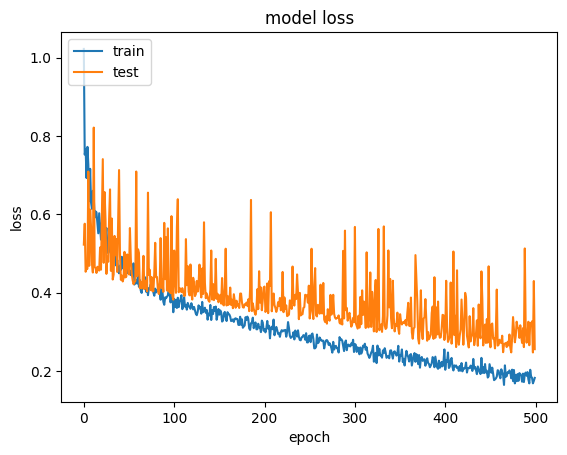

In [50]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Accuracy of CNN graph

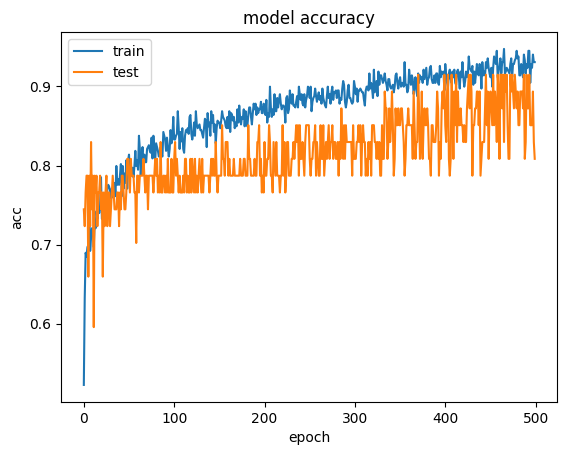

In [51]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from numpy import max, random, array, round
from ensemble import EnsembleNNClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.svm import SVC
import matplotlib.pyplot as plt


In [54]:
def load_scoliosis_data():
    dataset = read_excel('data/pone.0261511.s001.xlsx',
                         sheet_name='health-scoliotic patients')
    X = dataset.drop(['Patients','y'], axis=1)
    y = dataset['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=90)
    return X_train, y_train, X_test, y_test

if __name__ == "__main__":
    X_train, y_train, X_test, y_test = load_scoliosis_data()


In [62]:
# Create the SVM model
svm_model = SVC()


In [65]:
# Train the SVM model
svm_model.fit(X_train, y_train)


SVC()

In [57]:
# Evaluate the SVM model on the test set
svm_test_accuracy = svm_model.score(X_test, y_test)

# Print the evaluation results
print('SVM test accuracy:', svm_test_accuracy)


SVM test accuracy: 0.8723404255319149


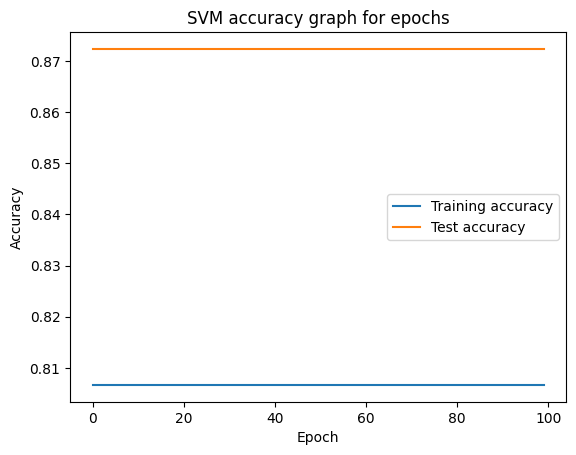

In [68]:
# Define a function to plot the SVM accuracy graph for epochs
def plot_svm_accuracy_graph(svm_model, X_train, y_train, X_test, y_test, epochs=100):
    # Train the SVM model for a range of epochs
    svm_train_accuracies = []
    svm_test_accuracies = []
    for epoch in range(1, epochs + 1):
        svm_model.fit(X_train, y_train)
        svm_train_accuracy = svm_model.score(X_train, y_train)
        svm_test_accuracy = svm_model.score(X_test, y_test)
        svm_train_accuracies.append(svm_train_accuracy)
        svm_test_accuracies.append(svm_test_accuracy)

    # Plot the training and test accuracies
    plt.plot(svm_train_accuracies, label='Training accuracy')
    plt.plot(svm_test_accuracies, label='Test accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('SVM accuracy graph for epochs')
    plt.legend()
    plt.show()

# Plot the SVM accuracy graph for epochs
plot_svm_accuracy_graph(svm_model, X_train, y_train, X_test, y_test, epochs=100)


In [69]:
predict_x=model.predict(X_test)
predictions=np.argmax(predict_x,axis=1)

2/2 [==============================] - 0s 9ms/step


In [70]:
predictions

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1])

In [71]:
y_test

426    1
87     0
369    1
355    1
336    1
339    1
385    1
374    1
430    1
118    0
181    0
288    1
38     0
310    1
97     0
433    1
318    1
13     0
411    1
39     0
28     0
267    1
209    1
373    1
216    1
327    1
239    1
407    1
316    1
108    0
99     0
130    0
381    1
116    0
274    1
236    1
465    1
397    1
345    1
366    1
164    0
388    1
243    1
298    1
330    1
266    1
48     0
Name: y, dtype: int64

In [72]:
new_Ytest = y_test.astype(int)

In [73]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.50      0.61        14
           1       0.82      0.94      0.87        33

    accuracy                           0.81        47
   macro avg       0.80      0.72      0.74        47
weighted avg       0.80      0.81      0.79        47



In [74]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

[[ 7  7]
 [ 2 31]]


In [85]:
model_name = 'Copy of Ensemble-Deep-Learning-to-Classify-Scoliosis-and-Healthy-Subjects.ipynb'
save_dir = '/content/drive/My Drive/Colab Notebooks'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/Colab Notebooks/Copy of Ensemble-Deep-Learning-to-Classify-Scoliosis-and-Healthy-Subjects.ipynb 


In [86]:
loaded_model = keras.models.load_model('/content/drive/My Drive/ng-to-ClColab Notebooks/Copy of Ensemble-Deep-Learniassify-Scoliosis-and-Healthy-Subjects.ipynb')
loaded_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 27, 128)           768       
                                                                 
 activation_3 (Activation)   (None, 27, 128)           0         
                                                                 
 dropout_2 (Dropout)         (None, 27, 128)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 3, 128)            82048     
                                                                 
 activation_4 (Activation)   (None, 3, 128)            0         
                                                      

In [87]:
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

2/2 [==============================] - 0s 12ms/step - loss: 0.2553 - accuracy: 0.8085
Restored model, accuracy: 80.85%
